## Домашнее задание Numpy Neural Net Exploration (50 баллов)

В этом домашнем задании требуется провести набор экспериментов с нейронной сетью. Для проведения экспериментов нужно доработать представленный фреймворк для обучения нейронной сети на Numpy в проекте **Numpy_NN** c **hinge_loss** функцией ошибки. 

Ссылка на проект - https://github.com/runnerup96/Numpy-NN-Framework

Все необходимые доработки обозначены в проекте тегом **TODO**.

В ноутбуке только сами эксперименты с помощью данных команд - все доработки делать внутри фреймворка.

In [2]:
import glob
import pickle
import sys
import os
import importlib

In [3]:
sys.path.append(os.path.join(os.getcwd(), "src"))
import nn, dataset, optimization, training

In [44]:
import numpy as np
from sklearn.metrics import classification_report
from dataset import dataloader
from nn.module.sequential import Sequential
from nn.layers.linear import Linear
from nn.layers.batch_norm import BatchNorm
from nn.layers.dropout import Dropout
from nn.activations.relu import ReLU
from nn.activations.sigmoid import Sigmoid
from nn.activations.tanh import Tanh
from optimization.adam_optimizer import Adam
from nn import loss_functions
from training.train import train
import visualization_utils as viz_utils
from utils import progress_bar, gradient_check

Вам нужно провести набор экспериментов с CIFAR датасетом и исследовать поведение нейронной сети на этом датасете при разных архитектурах. Пример 1ого эксперимента можно найти в ноутбуке **test_CIFAR_training.py**

Ваши эксперименты должы быть логичны - старайтесь последовательно строить архитектуру и попытайтесь к концу эксприментов определить комбинацию компонент нейронной сети для лучшего качества. Также же вы можете расширять количеcтво экспериментов, подтверждая это соответсвующими выводами. 

В каждом эксперименте должен быть:
    
    * Процесс обучения нейронной сети с помощью training.train.train
    * Проверка градиента для каждой архитектуры нейронной сети с помощью utils.gradient_check(если это указано в описании эксперимента)
    * Визуализация обучения - воспользоваться методом visualization_utils.plot_learning_curves
    * Рассчет точности общей точности модели и рассчет по классовой точности с помощью sklearn.metrics.classification_report
    * Ваш вывод по результату эксперимента
    
В каждом эксперименте должен быть каждый пункт иначе эксперимент не оценивается. Каждый эксперимент оценивается в **4 балла**. За расширение пространства экспериментов и реализации своих идей можно дополнительно получить до **6 баллов**.

В данном ДЗ оценивается качество работы доработанного вами фреймворка, качество проведения эксперимента и полученный результат. 

## Предобработка данных

In [6]:
files = glob.glob("cifar-10-batches-py/**")
files = [item.split('/')[-1] for item in files]
for file in sorted(files):
    print(f"-{file}")

-batches.meta
-data_batch_1
-data_batch_2
-data_batch_3
-data_batch_4
-data_batch_5
-readme.html
-test_batch


In [7]:
with open("cifar-10-batches-py/data_batch_1", "rb") as f:
    train_dataset_1 = pickle.load(f, encoding="bytes")

In [8]:
for key in train_dataset_1.keys():
    print(f"-{key.decode('utf-8')}")

-batch_label
-labels
-data
-filenames


In [9]:
train_dataset_1[b'batch_label'].decode('utf-8')

'training batch 1 of 5'

In [10]:
print("Первые 10 названий:")
for name in train_dataset_1[b'filenames'][:10]:
    print(f"-{name.decode('utf-8')}")

Первые 10 названий:
-leptodactylus_pentadactylus_s_000004.png
-camion_s_000148.png
-tipper_truck_s_001250.png
-american_elk_s_001521.png
-station_wagon_s_000293.png
-coupe_s_001735.png
-cassowary_s_001300.png
-cow_pony_s_001168.png
-sea_boat_s_001584.png
-tabby_s_001355.png


In [11]:
print(train_dataset_1[b'labels'][:10])

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


In [12]:
with open("cifar-10-batches-py/batches.meta", "rb") as f:
    classes_names = pickle.load(f, encoding="bytes")

for ind, name in enumerate(classes_names[b'label_names']):
    print(f"{ind}: {name.decode('utf-8')}")

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [13]:
print(f"Количество данных: {len(train_dataset_1[b'data'])}")
print(f"Размер вектора: {train_dataset_1[b'data'][0].shape}")

Количество данных: 10000
Размер вектора: (3072,)


In [14]:
with open("cifar-10-batches-py/data_batch_2", "rb") as f:
    train_dataset_2 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_3", "rb") as f:
    train_dataset_3 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_4", "rb") as f:
    train_dataset_4 = pickle.load(f, encoding="bytes")

with open("cifar-10-batches-py/data_batch_5", "rb") as f:
    train_dataset_5 = pickle.load(f, encoding="bytes")

In [15]:
datasets = [train_dataset_1, train_dataset_2, train_dataset_3, 
            train_dataset_4, train_dataset_5]

labels = list(range(10))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|{8:^{9}}|{10:^{11}}|".format(
    "Data 1", 6, "Data 2", 6, "Data 3", 6, "Data 4", 6, "Data 5", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in datasets:
        print("{0:^{1}}|".format(dataset[b'labels'].count(label), 6), end='')
        label_num += dataset[b'labels'].count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|{}|{}|".format(
    "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|======|======|
|Label|Data 1|Data 2|Data 3|Data 4|Data 5| Sum  |
|=====|======|======|======|======|======|======|
|  0  | 1005 | 984  | 994  | 1003 | 1014 | 5000 |
|  1  | 974  | 1007 | 1042 | 963  | 1014 | 5000 |
|  2  | 1032 | 1010 | 965  | 1041 | 952  | 5000 |
|  3  | 1016 | 995  | 997  | 976  | 1016 | 5000 |
|  4  | 999  | 1010 | 990  | 1004 | 997  | 5000 |
|  5  | 937  | 988  | 1029 | 1021 | 1025 | 5000 |
|  6  | 1030 | 1008 | 978  | 1004 | 980  | 5000 |
|  7  | 1001 | 1026 | 1015 | 981  | 977  | 5000 |
|  8  | 1025 | 987  | 961  | 1024 | 1003 | 5000 |
|  9  | 981  | 985  | 1029 | 983  | 1022 | 5000 |
|=====|======|======|======|======|======|======|


In [16]:
train_dataset = []

for dataset in datasets:
    for vec, label in zip(dataset[b'data'], dataset[b'labels']):
        train_dataset.append((vec / 256, label))

In [17]:
np.random.seed(42)
np.random.shuffle(train_dataset)

train_data = []
valid_data = []

cnt = {ind: 0 for ind in range(10)}

for vec, label in train_dataset:
    if cnt[label] < 1000:
        cnt[label] += 1
        valid_data.append((vec, label))
    else:
        train_data.append((vec, label))

In [18]:
with open("cifar-10-batches-py/test_batch", "rb") as f:
    test_dataset = pickle.load(f, encoding="bytes")

test_data = []
for vec, label in zip(test_dataset[b'data'], test_dataset[b'labels']):
    test_data.append((vec / 256, label))

In [19]:
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))
print("|Label|{0:^{1}}|{2:^{3}}|{4:^{5}}|{6:^{7}}|".format(
    "Train", 6, "Valid", 6, "Test", 6, "Sum", 6))
print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

labels = list(range(10))
for label in labels:
    print("|{0:^{1}}|".format(label, 5), end='')
    label_num = 0
    for dataset in (train_data, valid_data, test_data):
        labels_data = [item[1] for item in dataset]
        print("{0:^{1}}|".format(labels_data.count(label), 6), end='')
        label_num += labels_data.count(label)
    print("{0:^{1}}|".format(label_num, 6))

print("|=====|{}|{}|{}|{}|".format("=" * 6, "=" * 6, "=" * 6, "=" * 6))

|=====|======|======|======|======|
|Label|Train |Valid | Test | Sum  |
|=====|======|======|======|======|
|  0  | 4000 | 1000 | 1000 | 6000 |
|  1  | 4000 | 1000 | 1000 | 6000 |
|  2  | 4000 | 1000 | 1000 | 6000 |
|  3  | 4000 | 1000 | 1000 | 6000 |
|  4  | 4000 | 1000 | 1000 | 6000 |
|  5  | 4000 | 1000 | 1000 | 6000 |
|  6  | 4000 | 1000 | 1000 | 6000 |
|  7  | 4000 | 1000 | 1000 | 6000 |
|  8  | 4000 | 1000 | 1000 | 6000 |
|  9  | 4000 | 1000 | 1000 | 6000 |
|=====|======|======|======|======|


In [20]:
train_matrix = np.array([item[0] for item in train_data])
D = np.var(train_matrix, axis=0)
E = np.mean(train_matrix, axis=0)

for ind in range(len(train_data)):
    train_data[ind] = (train_data[ind][0] - E, train_data[ind][1])
    train_data[ind] = (train_data[ind][0] / np.sqrt(D), train_data[ind][1])

for ind in range(len(valid_data)):
    valid_data[ind] = (valid_data[ind][0] - E, valid_data[ind][1])
    valid_data[ind] = (valid_data[ind][0] / np.sqrt(D), valid_data[ind][1])

for ind in range(len(test_data)):
    test_data[ind] = (test_data[ind][0] - E, test_data[ind][1])
    test_data[ind] = (test_data[ind][0] / np.sqrt(D), test_data[ind][1])

In [50]:
class Start():
    def __init__(
        self,
        train_data, 
        valid_data, 
        model, 
        epochs: int, 
        lr: float = 1e-3, 
        optimizer: str = "Adam", 
        batch_size:int = 2000, 
        eps: float = 1e-3, 
        check_grads: bool = True,
        alpha1=None,
        alpha2=None
    ):
        self.train_data = train_data
        self.valid_data = valid_data
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.eps = eps
        self.check_grads = check_grads
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        
    def run_check_grad(self):
        print("Running check gradients...")
        print("_"*100)
        train_dataloader = dataloader.Dataloader(self.train_data, 100, False)
        for x, y in train_dataloader:
            break
        gradient_check(x, y, self.model, num_last=1, optim_method=self.optimizer, eps=1e-2)
        
    def train(self):
        print("Running training model...")
        print("_"*100)
        train_loss_history, valid_loss_history, train_acc_history, valid_acc_history = train(
        dataset=self.train_data,
        model=self.model,
        epochs=self.epochs,
        lr=self.lr,
        valid_dataset=self.valid_data,
        batch_size=self.batch_size,
        optim_method=self.optimizer, 
        alpha1=self.alpha1,
        alpha2=self.alpha2,
        )
        if self.check_grads:
            self.run_check_grad()
        return train_loss_history, valid_loss_history, train_acc_history, valid_acc_history
        
    def draw_training_curve(self, train_loss_history, valid_loss_history, train_acc_history, valid_acc_history):
        print("Drawing training curves...")
        print("_"*100)
        viz_utils.plot_learning_curves(
        train_loss_history, valid_loss_history,
        train_acc_history, valid_acc_history
        )
        
    def validate(self):
        print("Validation...")
        print("_"*100)
        test_dataloader = dataloader.Dataloader(test_data, 10000, False)
        self.model.eval()
        counter = test_loss = test_acc = 0
        
        for vecs, labels in test_dataloader:
            counter += 1
            out = self.model.forward(vecs)
            loss = loss_functions.hinge_loss.hinge_loss(out, labels)
            test_loss += loss.item()
            pred_labels = np.argmax(out.array, axis=-1)
            test_acc += np.sum(pred_labels == labels) / len(labels)
        test_loss /= counter
        test_acc /= counter

        print(f"Ошибка на тесте: {test_loss:.4f}")
        print(f"Точность на тесте: {test_acc:.4f}")
        return labels, pred_labels
        
    def get_classification_report(self, labels, pred_labels):
        print("getting classification report")
        print("_"*100)
        print(classification_report(labels, pred_labels))
        
    def run(self):
        train_loss_history, valid_loss_history, train_acc_history, valid_acc_history = self.train()
        self.draw_training_curve(train_loss_history, valid_loss_history, train_acc_history, valid_acc_history)
        labels, pred_labels = self.validate()
        self.get_classification_report(labels, pred_labels)

### Модель из ноутбука

Sequential(
	Linear(3072, 768, bias=True),
	Linear(768, 128, bias=True),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15| 13.0338  | 0.3023  | 13.3573  | 0.3002  | 0.003084 |   5.6    |   5.6    |
| 2/15|  7.0331  | 0.3233  |  7.2749  | 0.3126  | 0.001662 |   6.9    |   12.5   |
| 3/15|  5.3908  | 0.3555  |  5.8397  | 0.3406  | 0.001295 |   7.7    |   20.2   |
| 4/15|  5.2785  | 0.3755  |  5.3661  | 0.3620  | 0.000622 |   8.1    |   28.3   |
| 5/15|  4.2891  | 0.3795  |  5.1658  | 0.3590  | 0.000723 |   8.2    |   36.5   |
| 6/15|  4.5670  | 0.3853  |  4.9956  | 0.3541  | 0.000894 |   8.8    |   45.3   |
| 7/15|  4.6295  | 0.3877  |  4.8118  | 0.3588  | 0.001065 |   9.6    |   55.0   |
| 8/15|  4.4170  | 0.4047  |  4.6314  | 0.3704  | 0.000589 |   10.4   |   65.4   |
| 9/15|  4.1245  | 0.3953  |  4.7739  | 0.3

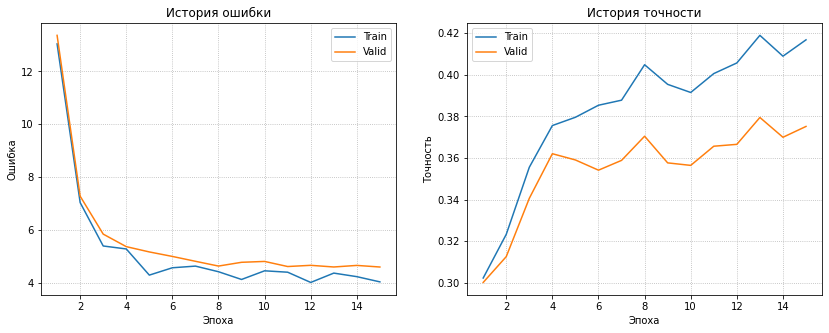

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.5788
Точность на тесте: 0.3804
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.40      0.47      0.43      1000
           1       0.47      0.41      0.44      1000
           2       0.27      0.30      0.28      1000
           3       0.28      0.26      0.27      1000
           4       0.32      0.31      0.32      1000
           5       0.34      0.24      0.28      1000
           6       0.43      0.45      0.44      1000
           7       0.42      0.41      0.42      1000
           8       0.46      0.47      0.46      1000
           9       0.41      0.47      0.44      1000

    accuracy                           0.38     10000
   macro avg       0.38      0.38      0.38     10000


In [55]:
np.random.seed(42)
model = Sequential(
    Linear(3072, 768),
    Linear(768, 128),
    Linear(128, 10)
)

display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

### Эксперимент 1 Построение нейронной сети с ReLU функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  

Sequential(
	Linear(3072, 768, bias=True),
	ReLU(),
	Linear(768, 128, bias=True),
	ReLU(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.3257  | 0.3590  |  5.5565  | 0.3444  | 0.005111 |   6.2    |   6.2    |
| 2/15|  4.2988  | 0.4365  |  4.3098  | 0.4002  | 0.003827 |   7.4    |   13.6   |
| 3/15|  3.6004  | 0.4726  |  4.0308  | 0.4242  | 0.002453 |   7.5    |   21.1   |
| 4/15|  3.2491  | 0.4955  |  3.9075  | 0.4288  | 0.002202 |   8.5    |   29.6   |
| 5/15|  2.6215  | 0.5375  |  3.6881  | 0.4484  | 0.000955 |   10.4   |   40.1   |
| 6/15|  2.4916  | 0.5712  |  3.6449  | 0.4606  | 0.001206 |   15.4   |   55.5   |
| 7/15|  2.2161  | 0.5857  |  3.5980  | 0.4589  | 0.000605 |   25.8   |   81.3   |
| 8/15|  2.2493  | 0.6199  |  3.5706  | 0.4630  | 0.000787 |   17.5   |   98.7   |
| 9/15|  1.8434  | 0.6413  |  3.4888  | 0.4

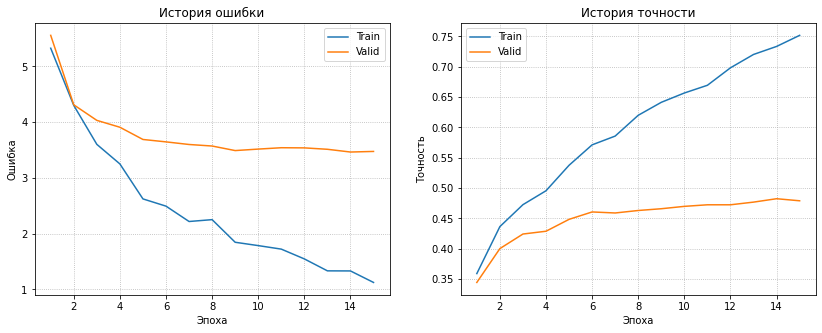

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4506
Точность на тесте: 0.4754
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.60      0.53      0.56      1000
           1       0.56      0.54      0.55      1000
           2       0.36      0.38      0.37      1000
           3       0.33      0.34      0.34      1000
           4       0.39      0.39      0.39      1000
           5       0.40      0.38      0.39      1000
           6       0.56      0.44      0.49      1000
           7       0.50      0.57      0.53      1000
           8       0.59      0.64      0.61      1000
           9       0.48      0.53      0.51      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000


In [56]:
model = Sequential(
    Linear(3072, 768),
    ReLU(),
    Linear(768, 128),
    ReLU(),
    Linear(128, 10)
)

display(model)
start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Добавление слоёв с Relu улучшило результат

### Эксперимент 2 Построение нейронной сети с Sigmoid функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.    

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.1071  | 0.3515  |  4.8422  | 0.3428  | 0.015792 |   8.1    |   8.1    |
| 2/15|  4.4494  | 0.3948  |  4.3590  | 0.3851  | 0.012140 |   7.7    |   15.9   |
| 3/15|  3.7654  | 0.4224  |  4.1274  | 0.4028  | 0.010246 |   8.4    |   24.3   |
| 4/15|  4.0349  | 0.4389  |  3.9717  | 0.4188  | 0.009311 |   8.0    |   32.3   |
| 5/15|  3.8450  | 0.4500  |  3.8914  | 0.4238  | 0.007785 |   12.0   |   44.3   |
| 6/15|  3.5935  | 0.4655  |  3.7869  | 0.4361  | 0.006963 |   14.4   |   58.7   |
| 7/15|  3.5517  | 0.4803  |  3.7308  | 0.4430  | 0.004698 |   22.3   |   81.0   |
| 8/15|  3.3041  | 0.4900  |  3.6846  | 0.4440  | 0.005045 |   24.7   |  105.7   |
| 9/15|  3.2546  | 0.4993  |  3.6354  | 0.4

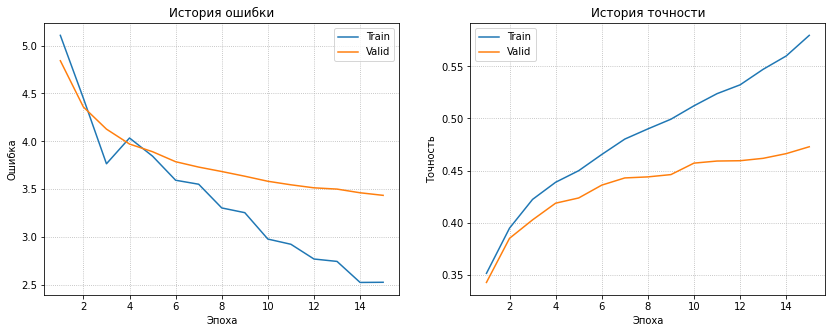

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4033
Точность на тесте: 0.4797
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.56      0.55      0.56      1000
           1       0.55      0.55      0.55      1000
           2       0.38      0.34      0.36      1000
           3       0.35      0.32      0.33      1000
           4       0.43      0.36      0.39      1000
           5       0.38      0.43      0.40      1000
           6       0.49      0.55      0.51      1000
           7       0.52      0.52      0.52      1000
           8       0.58      0.64      0.61      1000
           9       0.52      0.54      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000


In [57]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Видно, что accuracy немного лучше, чем у сетки с слоями активации ReLu. Возможно, если увеличить число эпох или размер батча, то разница будет более заметной

### Эксперимент 3 Построение нейронной сети с TanH функцией активации

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации на ваше усмотрение, но указанная в эксперименте функция должна быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

Sequential(
	Linear(3072, 768, bias=True),
	Tanh(),
	Linear(768, 128, bias=True),
	Tanh(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.6549  | 0.3308  |  5.4157  | 0.3169  | 0.001714 |   8.0    |   8.0    |
| 2/15|  4.5972  | 0.3828  |  4.8459  | 0.3534  | 0.000733 |   8.1    |   16.1   |
| 3/15|  4.2381  | 0.4242  |  4.5961  | 0.3755  | 0.000760 |   8.4    |   24.5   |
| 4/15|  3.7622  | 0.4615  |  4.4322  | 0.3858  | 0.000464 |   8.3    |   32.8   |
| 5/15|  3.6131  | 0.4999  |  4.3209  | 0.4000  | 0.000402 |   8.4    |   41.2   |
| 6/15|  3.0864  | 0.5323  |  4.2227  | 0.4121  | 0.000339 |   8.7    |   49.8   |
| 7/15|  2.8349  | 0.5566  |  4.2118  | 0.4119  | 0.000371 |   8.6    |   58.4   |
| 8/15|  2.5822  | 0.5820  |  4.2126  | 0.4116  | 0.000337 |   9.3    |   67.7   |
| 9/15|  2.4993  | 0.6159  |  4.2151  | 0.4

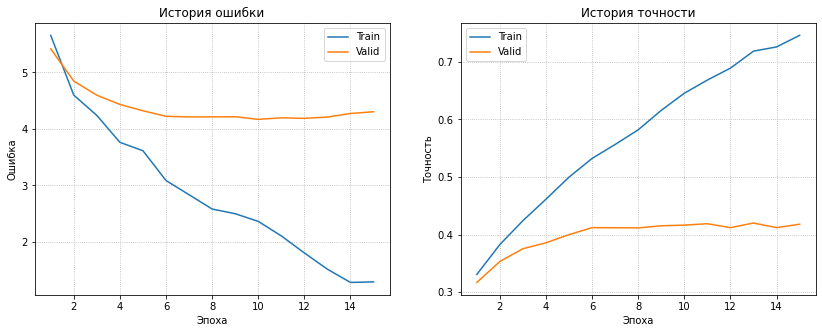

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.3051
Точность на тесте: 0.4214
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      1000
           1       0.50      0.44      0.47      1000
           2       0.33      0.29      0.31      1000
           3       0.29      0.22      0.25      1000
           4       0.34      0.41      0.37      1000
           5       0.35      0.33      0.34      1000
           6       0.44      0.50      0.47      1000
           7       0.43      0.42      0.42      1000
           8       0.56      0.59      0.57      1000
           9       0.44      0.52      0.48      1000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.42     10000


In [59]:
model = Sequential(
    Linear(3072, 768),
    Tanh(),
    Linear(768, 128),
    Tanh(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Видим, что accuracy хуже, чем у сеток со слоями активации ReLu или Sigmoid, но при этом лучше, чем у сетки без слоёв активации при том, что конечный train_accuracy у сетки с TanH значительно выше, чем у сетки с Sigmoid или без слоёв активации и только чуть хуже чем у сетки с ReLu

### Эксперимент 4 Построение нейронной сети с Dropout слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.  Подберите оптимальную вероятность в dropout. 

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Dropout(p=0.2),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  5.4537  | 0.2827  |  5.9094  | 0.2820  | 0.004155 |   8.8    |   8.8    |
| 2/15|  5.0198  | 0.3194  |  5.2835  | 0.3154  | 0.002667 |   9.5    |   18.3   |
| 3/15|  4.5709  | 0.3467  |  4.9403  | 0.3427  | 0.001626 |   8.5    |   26.8   |
| 4/15|  4.0676  | 0.3645  |  4.7636  | 0.3535  | 0.002060 |   8.8    |   35.6   |
| 5/15|  4.0845  | 0.3814  |  4.6408  | 0.3670  | 0.002708 |   8.8    |   44.4   |
| 6/15|  4.0149  | 0.3941  |  4.5059  | 0.3786  | 0.002628 |   9.0    |   53.4   |
| 7/15|  3.7750  | 0.4068  |  4.4359  | 0.3867  | 0.001037 |   9.1    |   62.6   |
| 8/15|  3.8070  | 0.4133  |  4.3833  | 0.3884  | 0.001535 |   11.0   |   73.5   |
| 9/15|  3.6862  | 0.4194  |  4.3526  | 0.3

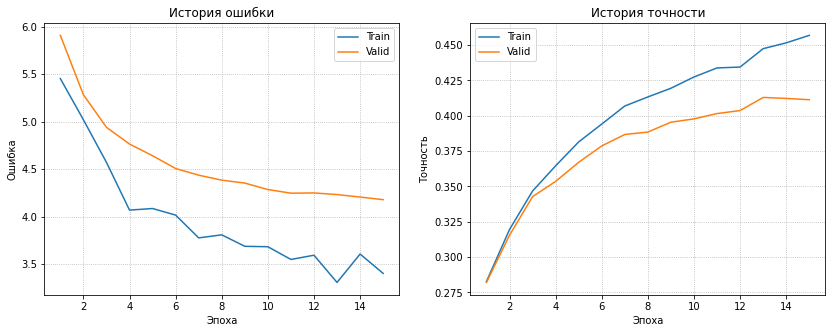

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 4.2205
Точность на тесте: 0.4103
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.50      0.41      0.45      1000
           1       0.65      0.34      0.45      1000
           2       0.32      0.32      0.32      1000
           3       0.28      0.35      0.31      1000
           4       0.40      0.30      0.35      1000
           5       0.43      0.16      0.23      1000
           6       0.37      0.65      0.48      1000
           7       0.48      0.44      0.46      1000
           8       0.40      0.74      0.52      1000
           9       0.52      0.39      0.45      1000

    accuracy                           0.41     10000
   macro avg       0.44      0.41      0.40     10000


In [60]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Dropout(0.2),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Видно, что с добавлением drop out качество хуже, чем у аналогичной сетки (в плане у такой же сетки с слоями активации Sigmoid как и здесь, но без использования drop out)

### Эксперимент 5 Построение нейронной сети с Batchnorm слоем

Реализуйте эксперимент, доработав соответсвующие модули Numpy_NN фреймворка. Количество слоев, функций на ваше усмотрение. Можно добавлять любые другие функции активации, слои на ваше усмотрение, но указанный в эксперименте слой должен быть обязательно. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	BatchNorm(in_dim=768, eps=1e-05),
	Linear(768, 128, bias=True),
	Sigmoid(),
	BatchNorm(in_dim=128, eps=1e-05),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  6.1174  | 0.3104  |  5.4429  | 0.3051  | 0.001522 |   10.7   |   10.7   |
| 2/15|  4.8586  | 0.3437  |  5.4122  | 0.3271  | 0.000669 |   9.7    |   20.4   |
| 3/15|  4.3238  | 0.3634  |  5.3636  | 0.3343  | 0.000504 |   10.0   |   30.3   |
| 4/15|  4.3919  | 0.3659  |  5.4970  | 0.3414  | 0.000538 |   9.9    |   40.2   |
| 5/15|  3.8654  | 0.3690  |  5.5880  | 0.3255  | 0.000307 |   10.5   |   50.8   |
| 6/15|  3.4878  | 0.3736  |  5.5576  | 0.3394  | 0.000391 |   11.2   |   62.0   |
| 7/15|  3.3146  | 0.3958  |  5.5722  | 0.3460  | 0.000367 |   11.0   |   73.0   |
| 8/15|  3.2510  | 0.4062  |  5.5696  | 0.3435  | 0.000390 |   12.8   |   85.8   |
| 9/15|  2.8278  | 0.4186  |  5.5716  | 0.3

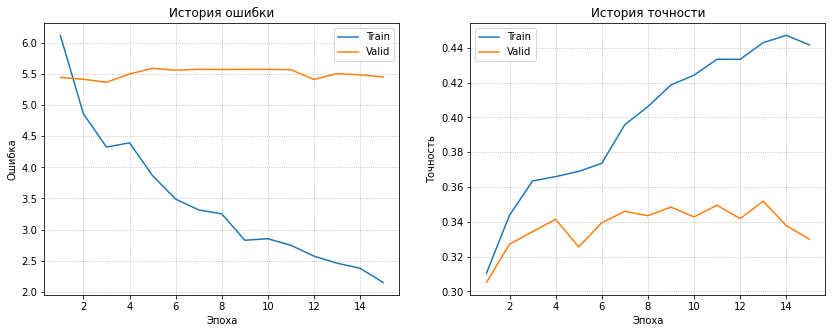

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 5.5902
Точность на тесте: 0.3028
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.36      0.59      0.44      1000
           1       0.59      0.16      0.26      1000
           2       0.26      0.32      0.28      1000
           3       0.18      0.32      0.23      1000
           4       0.21      0.62      0.31      1000
           5       0.35      0.22      0.27      1000
           6       0.48      0.14      0.21      1000
           7       0.50      0.33      0.40      1000
           8       0.75      0.09      0.17      1000
           9       0.61      0.24      0.34      1000

    accuracy                           0.30     10000
   macro avg       0.43      0.30      0.29     10000


In [61]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    BatchNorm(768),
    Linear(768, 128),
    Sigmoid(),
    BatchNorm(128),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, batch_size=3000)
start_train.run()

Accuracy значительно хуже даже чем у сетки без дополнительных слоёв, не говоря уже о сравнении с сеткой с слоями Sigmoid или с drop out. Заметим, что ошибка на валидационной выборке не меняется, а совершает совсем небольшие колебания около прямой вида y = 5.5, в то время как на тренировочной выборке loss падает, а точность на 15ой эпохе хуже, чем на 14ой и на трейне, и на валидационной выборке.

### Эксперимент 6 Эксперимент с Adam оптимизатором 

Обучите вашу нейронную сеть с Adam оптимизатором. Подбор гиперпараметров на ваше усмотрение. Перед обучением проверьте с помощью utils.gradient_check градиент вашей модели.   

#### Без Adam

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  9.2280  | 0.1000  |  9.2369  | 0.1000  | 0.031081 |   6.4    |   6.4    |
| 2/15|  8.7391  | 0.1007  |  8.6968  | 0.1005  | 0.011150 |   7.2    |   13.6   |
| 3/15|  8.6476  | 0.1205  |  8.4278  | 0.1204  | 0.007549 |   7.0    |   20.6   |
| 4/15|  8.1748  | 0.1457  |  8.2180  | 0.1446  | 0.006318 |   8.0    |   28.6   |
| 5/15|  7.9717  | 0.1606  |  8.0199  | 0.1611  | 0.004814 |   7.1    |   35.7   |
| 6/15|  7.7093  | 0.1722  |  7.8323  | 0.1720  | 0.003543 |   7.3    |   43.0   |
| 7/15|  7.7271  | 0.1867  |  7.6561  | 0.1832  | 0.004716 |   7.9    |   50.9   |
| 8/15|  7.4275  | 0.2039  |  7.4905  | 0.1972  | 0.003192 |   8.2    |   59.1   |
| 9/15|  7.4065  | 0.2179  |  7.3388  | 0.2

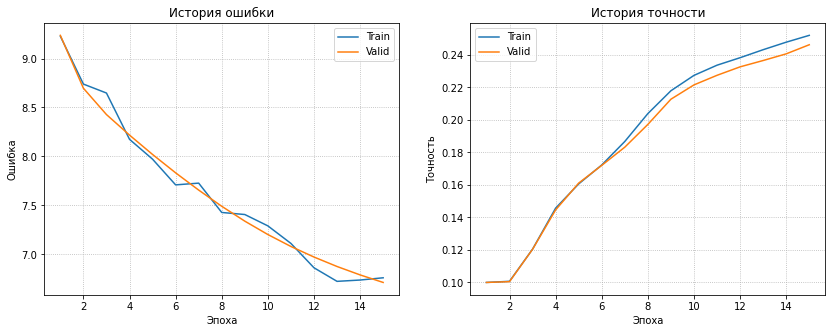

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 6.6897
Точность на тесте: 0.2549
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.29      0.49      0.36      1000
           1       0.32      0.22      0.26      1000
           2       0.14      0.02      0.03      1000
           3       0.15      0.28      0.20      1000
           4       0.15      0.01      0.03      1000
           5       0.44      0.09      0.15      1000
           6       0.21      0.46      0.29      1000
           7       0.21      0.18      0.19      1000
           8       0.42      0.35      0.38      1000
           9       0.31      0.45      0.36      1000

    accuracy                           0.25     10000
   macro avg       0.26      0.25      0.23     10000


In [62]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, optimizer="GD", batch_size=3000)
start_train.run()

#### с Adam

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/15|  4.6583  | 0.3574  |  4.7880  | 0.3484  | 0.008004 |   7.9    |   7.9    |                                                ] 0/1 0s>0s
| 2/15|  4.2806  | 0.3943  |  4.3338  | 0.3838  | 0.004331 |   7.8    |   15.7   |
| 3/15|  3.8867  | 0.4153  |  4.1142  | 0.4034  | 0.005276 |   8.2    |   23.9   |
| 4/15|  3.7365  | 0.4387  |  3.9563  | 0.4203  | 0.005353 |   8.0    |   31.9   |
| 5/15|  3.5698  | 0.4535  |  3.8521  | 0.4280  | 0.003925 |   9.6    |   41.6   |
| 6/15|  3.4156  | 0.4656  |  3.7682  | 0.4357  | 0.005966 |   10.9   |   52.4   |
| 7/15|  3.4279  | 0.4786  |  3.7053  | 0.4444  | 0.002938 |   11.4   |   63.9   |
| 8/15|  3.1279  | 0.4869  |  3.6760  | 0.4465  | 0.002812 |   11.2

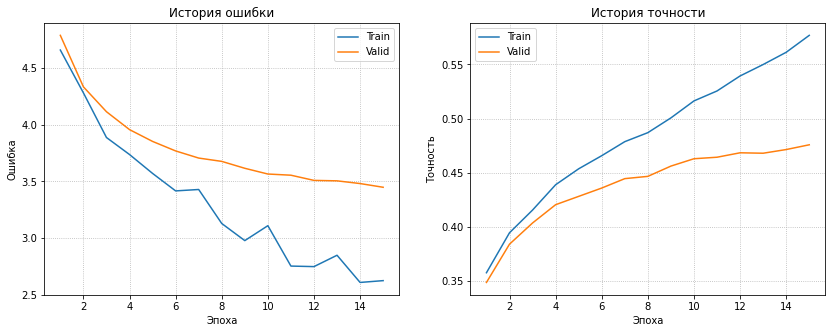

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4499
Точность на тесте: 0.4765
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.59      0.51      0.55      1000
           1       0.60      0.51      0.55      1000
           2       0.40      0.32      0.35      1000
           3       0.33      0.33      0.33      1000
           4       0.44      0.36      0.40      1000
           5       0.40      0.41      0.40      1000
           6       0.47      0.59      0.53      1000
           7       0.50      0.52      0.51      1000
           8       0.56      0.65      0.60      1000
           9       0.48      0.56      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000


In [63]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10)
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=15, optimizer="Adam", batch_size=3000)
start_train.run()

С оптимизатором Adam точность почти в 2 раза лучше, чем без Adam. Оно и очевидно, так как с Adam модель сходится значительно быстрее и градиент не застревает в локальных минимумах или седловых точках

### Эксперимент 7 Эксперимент c количеством слоев

Зафиксируйте модель и начинайте добавлять слои. Как меняется качество модели?

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  5.3767  | 0.3676  |  5.0930  | 0.3600  | 0.006518 |   8.9    |   8.9    |
| 2/30|  4.5234  | 0.4089  |  4.4584  | 0.3882  | 0.009977 |   7.4    |   16.3   |
| 3/30|  3.9284  | 0.4427  |  4.2452  | 0.4115  | 0.008938 |   7.7    |   24.0   |
| 4/30|  3.7268  | 0.4622  |  4.1195  | 0.4213  | 0.009034 |   7.7    |   31.8   |
| 5/30|  3.5582  | 0.4810  |  4.0607  | 0.4256  | 0.009197 |   8.0    |   39.8   |
| 6/30|  3.4560  | 0.4927  |  4.0571  | 0.4301  | 0.004892 |   7.9    |   47.6   |
| 7/30|  3.2848  | 0.5118  |  4.0173  | 0.4323  | 0.006089 |   8.0    |   55.7   |
| 8/30|  3.3048  | 0.5165  |  4.0038  | 0.4322  | 0.005587 |   7.9    |   63.6   |
| 9/30|  3.0058  | 0.5393  |  3.9665  | 0.4

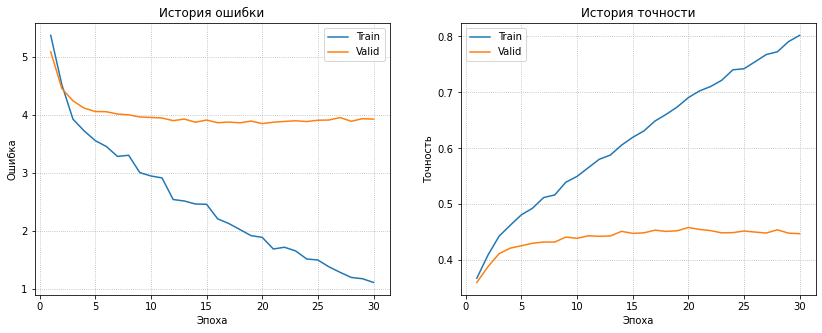

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.9142
Точность на тесте: 0.4571
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.53      0.56      0.54      1000
           1       0.57      0.49      0.53      1000
           2       0.35      0.33      0.34      1000
           3       0.31      0.31      0.31      1000
           4       0.40      0.33      0.36      1000
           5       0.35      0.37      0.36      1000
           6       0.47      0.55      0.51      1000
           7       0.48      0.47      0.48      1000
           8       0.58      0.64      0.61      1000
           9       0.52      0.53      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.46     10000


In [65]:
model = Sequential(
    Linear(3072, 768),
   Sigmoid(),
    Linear(768, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Sequential(
	Linear(3072, 512, bias=True),
	Sigmoid(),
	Linear(512, 256, bias=True),
	Sigmoid(),
	Linear(256, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  5.6074  | 0.3127  |  5.3867  | 0.3119  | 0.005505 |   8.4    |   8.4    |
| 2/30|  5.0670  | 0.3547  |  4.7935  | 0.3523  | 0.004231 |   6.6    |   15.0   |
| 3/30|  4.3695  | 0.3833  |  4.4312  | 0.3745  | 0.002074 |   6.5    |   21.5   |
| 4/30|  4.1623  | 0.4024  |  4.2426  | 0.3879  | 0.001048 |   6.7    |   28.2   |
| 5/30|  4.0472  | 0.4148  |  4.1271  | 0.3943  | 0.001850 |   6.6    |   34.8   |
| 6/30|  3.8115  | 0.4315  |  3.9945  | 0.4073  | 0.001479 |   6.8    |   41.6   |
| 7/30|  3.7536  | 0.4446  |  3.9152  | 0.4149  | 0.001816 |   6.7    |   48.3   |
| 8/30|  3.5784  | 0.4555  |  3.8514  | 0.4232  | 0.001683 |   6.8    |   55.2   |
| 9/30|  3.4762  | 0.4693  |  3.7632  | 0.4

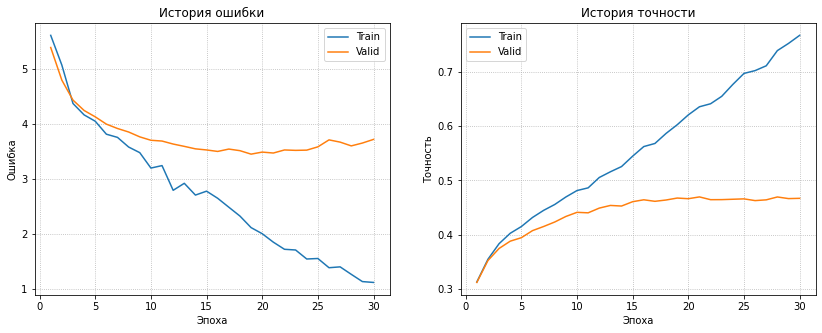

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.7933
Точность на тесте: 0.4555
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.57      0.47      0.51      1000
           1       0.60      0.52      0.55      1000
           2       0.32      0.35      0.34      1000
           3       0.33      0.27      0.29      1000
           4       0.38      0.39      0.38      1000
           5       0.33      0.47      0.39      1000
           6       0.48      0.54      0.51      1000
           7       0.56      0.43      0.49      1000
           8       0.54      0.65      0.59      1000
           9       0.56      0.47      0.51      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.46     10000


In [66]:
model = Sequential(
    Linear(3072, 512),
    Sigmoid(),
    Linear(512, 256),
    Sigmoid(),
    Linear(256, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/30|  4.8549  | 0.3630  |  4.7164  | 0.3566  | 0.008062 |   8.2    |   8.2    |
| 2/30|  4.3587  | 0.3957  |  4.3102  | 0.3795  | 0.004993 |   9.8    |   18.0   |
| 3/30|  4.0119  | 0.4212  |  4.0869  | 0.4014  | 0.005630 |   10.4   |   28.4   |
| 4/30|  3.8661  | 0.4392  |  3.9280  | 0.4195  | 0.002406 |   10.8   |   39.2   |
| 5/30|  3.6703  | 0.4556  |  3.8252  | 0.4297  | 0.003715 |   11.9   |   51.0   |
| 6/30|  3.4859  | 0.4677  |  3.7497  | 0.4374  | 0.002169 |   13.1   |   64.2   |
| 7/30|  3.4526  | 0.4785  |  3.6802  | 0.4450  | 0.002277 |   14.5   |   78.7   |
| 8/30|  3.3993  | 0.4903  |  3.6326  | 0.4498  | 0.001781 |   16.5   |   95.2   |
| 9/30|  3.0088  | 0.5004  |  3.5786  | 0.4

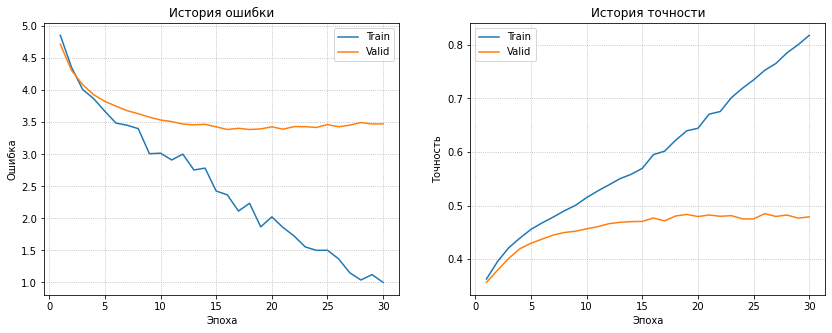

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.4924
Точность на тесте: 0.4855
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.60      0.52      0.55      1000
           1       0.66      0.51      0.57      1000
           2       0.36      0.41      0.38      1000
           3       0.33      0.37      0.35      1000
           4       0.42      0.38      0.40      1000
           5       0.42      0.38      0.40      1000
           6       0.52      0.54      0.53      1000
           7       0.52      0.52      0.52      1000
           8       0.57      0.69      0.62      1000
           9       0.52      0.54      0.53      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000


In [67]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=30, optimizer="Adam", batch_size=3000)
start_train.run()

Видно, что лучшая точность у модели с двумя слоями, а худшая у модели с тремя слоями активации, но при этом у модели с одним слоем активации точность почти такая же, как с тремя.

### Эксперимент 8 Эксперимент c количеством нейронов

Зафиксируйте модель и увеличьте количетсво весов в одном из слоев. Дает ли это прирост качества?

Sequential(
	Linear(3072, 768, bias=True),
	Sigmoid(),
	Linear(768, 128, bias=True),
	Sigmoid(),
	Linear(128, 10, bias=True)
)

Running training model...
____________________________________________________________________________________________________
|Epoch|Train loss|Train acc|Valid loss|Valid acc|  Grad/W  | Time, s  | Total, s |
|=====|==========|=========|==========|=========|==========|==========|==========|
| 1/20|  4.4339  | 0.4002  |  4.2977  | 0.3868  | 0.005784 |   17.7   |   17.7   |
| 2/20|  3.9048  | 0.4365  |  3.9210  | 0.4126  | 0.003128 |   16.2   |   33.9   |
| 3/20|  3.5217  | 0.4628  |  3.7681  | 0.4307  | 0.002493 |   14.9   |   48.8   |
| 4/20|  3.5204  | 0.4834  |  3.6398  | 0.4465  | 0.002368 |   16.4   |   65.2   |
| 5/20|  3.3198  | 0.5120  |  3.5632  | 0.4540  | 0.004480 |   15.8   |   81.0   |
| 6/20|  2.8140  | 0.5282  |  3.4572  | 0.4623  | 0.002517 |   14.7   |   95.7   |
| 7/20|  2.9380  | 0.5484  |  3.4180  | 0.4659  | 0.001302 |   14.2   |  109.9   |
| 8/20|  2.6865  | 0.5665  |  3.3790  | 0.4737  | 0.001890 |   12.9   |  122.9   |
| 9/20|  2.2849  | 0.5885  |  3.3590  | 0.4

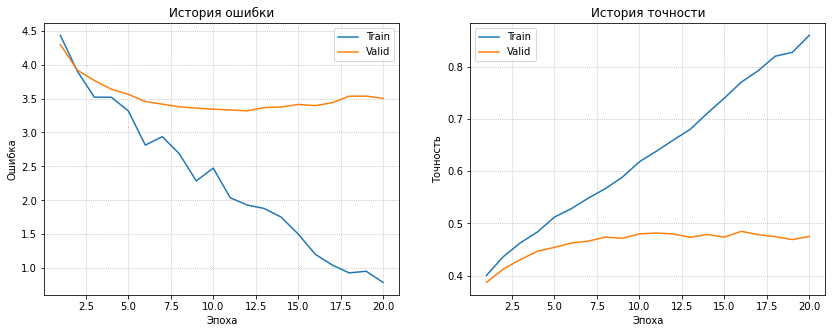

Validation...
____________________________________________________________________________________________________
Ошибка на тесте: 3.5575
Точность на тесте: 0.4843
getting classification report
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.60      0.51      0.55      1000
           1       0.61      0.59      0.60      1000
           2       0.39      0.31      0.34      1000
           3       0.33      0.35      0.34      1000
           4       0.37      0.46      0.41      1000
           5       0.39      0.40      0.40      1000
           6       0.50      0.53      0.52      1000
           7       0.54      0.49      0.52      1000
           8       0.58      0.67      0.62      1000
           9       0.54      0.52      0.53      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.48     10000


In [70]:
model = Sequential(
    Linear(3072, 768),
    Sigmoid(),
    Linear(768, 128),
    Sigmoid(),
    Linear(128, 10),
)
display(model)

start_train = Start(train_data, valid_data, model, epochs=20, optimizer="Adam", batch_size=1000)
start_train.run()

### Эксперимент 9 Эксперимент c размером батча

Зафиксируйте модель и обучитесь на разных размерах. Как размер батча влияет на процесс обучения?

### Эксперимент 10 Эксперимент с регуляризацией

Добавьте в процесс обучения L1/L2 регуляризацию. Повлияло ли это на качесвто? Выведите норму весов без регуляризации и с. 

### Эксперимент 11 Финальная архитектура

Как выглядит ваша финальная модель?